In [49]:
import awkward as ak
import numpy as np
import hist
from coffea import processor, hist as chist
from coffea.nanoevents.methods import vector
import uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.lookup_tools import extractor
import mplhep as hep
import matplotlib.pyplot as plt
import numba

@numba.njit
def clusterfillerhelper(llps, clusts):
    z = []
    r = []
    for llpevent, clustevent in zip(llps, clusts):
        for llp in llpevent:
            for clust in clustevent:
                if np.sqrt((llp.Eta - clust.Eta)**2 + (llp.Phi%(2*np.pi) - clust.Phi%(2*np.pi))**2) < .4:
                    z.append(abs(clust.Z))
                    r.append(clust.R)
    return z, r

@numba.njit
def clusterfillerhelper2(llps, clusts):
    zclust = []
    rclust = []
    zllp = []
    rllp = []
    for llpevent, clustevent in zip(llps, clusts):
        for llp in llpevent:
            if len(clustevent) > 0:
                zllp.append(abs(llp.Z))
                rllp.append(llp.R)
                for clust in clustevent:
                    if np.sqrt((llp.Eta - clust.Eta)**2 + (llp.Phi - clust.Phi)**2) < .4:
                        zclust.append(abs(clust.Z))
                        rclust.append(clust.R)

    return zllp, rllp, zclust, rclust

#coffea processor to abstract parallelization away from the histogram making
class MyProcessor(processor.ProcessorABC):
    def process(self, events):
        #dimensions of cms and muon subdetector region
        dim = {
            'csc':{},
            'dt':{},
            'cms':{},
        }

        s = 1e2 #cm
        dim['csc']['zmin'] = s * 5.5
        dim['csc']['zmax'] = s * 10.
        dim['csc']['rmin'] = s * 0.
        dim['csc']['rmax'] = s * 7.
        dim['dt']['zmin'] = s * 0.
        dim['dt']['zmax'] = s * 6.5
        dim['dt']['rmin'] = s * 4.
        dim['dt']['rmax'] = s * 7.5
        
        dim['cms']['zmin'] = s * 0.
        dim['cms']['zmax'] = s * 12.
        dim['cms']['rmin'] = s * 0.
        dim['cms']['rmax'] = s * 8.
        
        
        dataset = events.metadata['dataset']
        sumw = ak.sum(events.genWeight)

        def R(x, y):
            return np.sqrt(x**2 + y**2)

        #makes mask of particles who's parent is an LLP
        llpPIDmomCut = (events.gParticleMotherId == 1000023)
        #takes care of multi counting by picking index of first True value in each column
        llpDaughterInd = ak.argmax(llpPIDmomCut, axis = 1, keepdims = True)
        llpMomInd = events.gParticleMotherIndex[llpDaughterInd]
        #llpMomInd = (events.gParticleId == 1000023)
        
        llps = ak.zip(
                        {
                            'X': events.gParticleProdVertexX[llpDaughterInd],
                            'Y': events.gParticleProdVertexY[llpDaughterInd],
                            'Z': events.gParticleProdVertexZ[llpDaughterInd], 
                            'R': R(events.gParticleProdVertexX[llpDaughterInd],
                                   events.gParticleProdVertexY[llpDaughterInd]),
                            'pt': ak.ones_like(events.gParticlePhi[llpMomInd]),
                            'phi': events.gParticlePhi[llpMomInd],
                            'eta': events.gParticleEta[llpMomInd],
                            'mass': ak.ones_like(events.gParticlePhi[llpMomInd]),
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )

        cscs = ak.zip(
                        {
                            'X': events.cscRechitClusterX,
                            'Y': events.cscRechitClusterY,
                            'Z': events.cscRechitClusterZ, 
                            'R': R(events.cscRechitClusterX, events.cscRechitClusterY),
                            'pt': ak.ones_like(events.cscRechitClusterPhi),
                            'phi': events.cscRechitClusterPhi,
                            'eta': events.cscRechitClusterEta,
                            'mass': ak.ones_like(events.cscRechitClusterPhi),
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )

        dts = ak.zip(
                        {
                            'X': events.dtRechitClusterX,
                            'Y': events.dtRechitClusterY,
                            'Z': events.dtRechitClusterZ, 
                            'R': R(events.dtRechitClusterX, events.dtRechitClusterY),
                            'pt': ak.ones_like(events.dtRechitClusterPhi),
                            'phi': events.dtRechitClusterPhi,
                            'eta': events.dtRechitClusterEta,
                            'mass': ak.ones_like(events.dtRechitClusterPhi),
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )
        
        def cscCutter(p):
            cut = (
                    (abs(p.eta) < 2.4) & 
                    (abs(p.Z) > dim['csc']['zmin']) & (abs(p.Z) < dim['csc']['zmax']) &
                    (p.R < dim['csc']['rmax'])
                  )
            return p[cut]
        
        def dtCutter(p):
            cut = (
                    (p.R > dim['dt']['rmin']) & (p.R < dim['dt']['rmax']) &
                    (abs(p.Z) < dim['dt']['zmax'])
                  )
            return p[cut]
        
        llpcscs = cscCutter(llps)
        #cscs = cscCutter(cscs)
        
        llpdts = dtCutter(llps)
        #dts = dtCutter(dts)
        
        #hist initializer
        def hister(bins, region):
            return (
                    hist.Hist.new
                    .Reg(bins, dim[region]['zmin'], dim[region]['zmax'], name = 'z', label="z decay pos [cm]")
                    .Reg(bins, dim[region]['rmin'], dim[region]['rmax'], name = 'r', label="r decay pos [cm]")
                    .Double()
                   )
        
        bins = 30
        llpDecayHist = hister(bins, region = 'cms')
        
        llpCscDecayHist = hister(bins, region = 'cms')
        llpDtDecayHist = hister(bins, region = 'cms')
         
        cscClusterHist = hister(bins, region = 'cms')
        dtClusterHist = hister(bins, region = 'cms')   
        
        dRhist = (
                hist.Hist.new
                .Reg(bins, 0, 4, name = 'dR', label="dR")
                .Double()
                )

        clust_llp_pairs = ak.cartesian({"clusts": cscs, "llps": llps}, axis = 1, nested = True)
        delta_R = (clust_llp_pairs.clusts).delta_r(clust_llp_pairs.llps)
        dRhist.fill(ak.flatten(delta_R, None))
        
        print(clust_llp_pairs)
        #hist filler
        def filler(hist, p):
            z = abs(ak.flatten(p.Z, axis = None))
            r = ak.flatten(p.R, axis = None)
            hist.fill(z = z, r = r)

        def clusterfiller(hist, llps, clusts):
            clust_llp_pairs = ak.cartesian({"clusts": clusts, "llps": llps}, axis = 1, nested = True)
            delta_R = (clust_llp_pairs.clusts).delta_r(clust_llp_pairs.llps)
            matched = clust_llp_pairs.clusts[delta_R < 0.3]
            hist.fill(z = abs(ak.flatten(matched.Z, None)), r = ak.flatten(matched.R, None))
                      
        '''def clusterfiller(hist, llps, clusts):
            z, r = clusterfillerhelper(llps, clusts)
            hist.fill(z = z, r = r)
            
        def clusterfiller2(llphist, clusthist, llps, clusts):
            zllp, rllp, zclust, rclust = clusterfillerhelper2(llps, clusts)
            llphist.fill(z = zllp, r = rllp)
            clusthist.fill(z = zclust, r = rclust)'''
    

        '''clusterfiller2(llpDecayHist, cscClusterHist, llps, cscs)
        clusterfiller2(llpDecayHist, dtClusterHist, llps, dts) '''
        
        filler(llpDecayHist, llps)
        filler(llpCscDecayHist, llpcscs)
        filler(llpDtDecayHist, llpdts)
        clusterfiller(cscClusterHist, llpcscs, cscs)
        clusterfiller(dtClusterHist, llpdts, dts)

        '''filler(llpDecayHist, llps)
        filler(cscClusterHist, cscs)
        filler(dtClusterHist, dts) '''

        return {
            dataset: {
                "entries": len(events),
                "sumw": sumw,
                "ncsc" : ak.sum(events.nCscRechitClusters),
                "ndt" : ak.sum(events.nDtRechitClusters),
                
                "llpDecayHist": llpDecayHist,
                
                "llpCscDecayHist": llpCscDecayHist,
                "llpDtDecayHist": llpDtDecayHist,
                
                "cscClusterHist": cscClusterHist,
                "dtClusterHist": dtClusterHist,
                
                "dRhist": dRhist,
            }
        }

    def postprocess(self, accumulator):
        return accumulator

#digging up 
def rootAdds(directory):
    my_file = open(directory, "r")
    data = my_file.read().strip()
    data_into_list = data.split("\n")
    my_file.close()
    return data_into_list


In [50]:
fileset = {}
fileset['1e3mm'] = rootAdds('rootAdds/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000.txt')
fileset['3e2mm'] = rootAdds('rootAdds/BToKPhi_MuonGenFilter_mPhi1p0_ctau300.txt')

out = processor.run_uproot_job(
    fileset,
    treename = "ntuples/llp",
    processor_instance = MyProcessor(),
    executor = processor.futures_executor,
    executor_args = {"schema": BaseSchema, "workers": 6},
    maxchunks = 30,
)
out

Processing:   0%|          | 0/60 [00:00<?, ?chunk/s]

[[], [], [], [], [], [], [], [], [], ... eta: 5.41, mass: 1}}]], [], [], [], [], []]
[[], [], [], [[{clusts: {X: -127, Y: -174, Z: 842, ... [], [], [], [], [], []]
[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]
[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]
[[], [], [], [], [], [], [], ... pt: 1, phi: 1.95, eta: -0.189, mass: 1}}]], []]
[[[{clusts: {X: 27.3, Y: 228, Z: 614, R: 230, pt: 1, ... [], [], [], []]
[[], [], [], [], [], [], [[{clusts: {X: -84.8, ... [], [], [], [], [], [], []]
[[[{clusts: {X: -163, Y: -21.6, Z: -612, R: 164, pt: 1, ... eta: 3.5, mass: 1}}]]]
[[], [], [[{clusts: {X: -198, Y: -58.9, Z: -717, R: 206, ... [], [], [], [], [], []]
[[], [[{clusts: {X: 449, Y: 207, Z: 831, R: 495, pt: 1, ... [], [], [], [], []]
[[[{clusts: {X: -99.6, Y: 166, Z: -858, R: 193, pt: 1, ... [], [], [], []]
[[], [], [], [], [], [], [[{clusts: {X: 133, ... [], [], [], [], [], [], [], []]
[[], [], [], [], [], [], [], 

{'3e2mm': {'dRhist': Hist(Regular(30, 0, 4, name='dR', label='dR'), storage=Double()) # Sum: 4605.0 (6001.0 with flow),
  'entries': 104636,
  'sumw': 104636.0,
  'llpCscDecayHist': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 3761.0,
  'llpDtDecayHist': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 1720.0,
  'ncsc': 6001,
  'llpDecayHist': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 82055.0 (104636.0 with flow),
  'ndt': 1449,
  'cscClusterHist': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 2.0,
  'dtClusterHist': Hist(
    Regular(30, 0, 12

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fc1c8b167c0>, errorbar=None, legend_artist=None)]

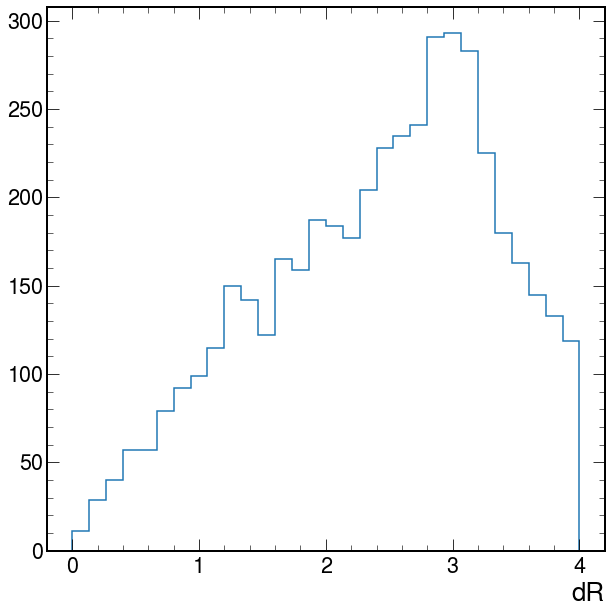

In [48]:
out['3e2mm']['dRhist'].plot()

AttributeError: module 'mplhep' has no attribute 'hist1dplot'

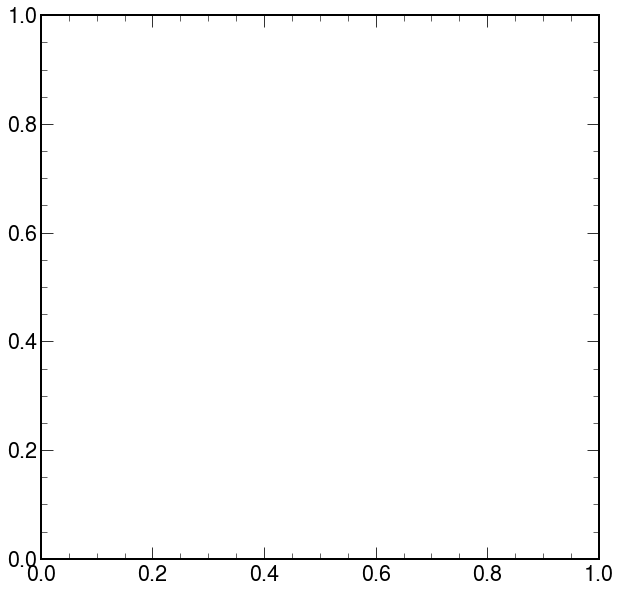

In [46]:
hep.style.use("CMS")
for junk in out:
    for jazz in out[junk]:
        if isinstance(out[junk][jazz], hist.Hist):
            fig, ax = plt.subplots()
            try:
                hep.hist2dplot(out[junk][jazz])
            except:
                hep.hist1dplot(out[junk][jazz])                
            fig.suptitle(f'{jazz} {junk}')
    

1e3mm


/tmp/ipykernel_12324/3701476389.py:13: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_12324/3701476389.py:13: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


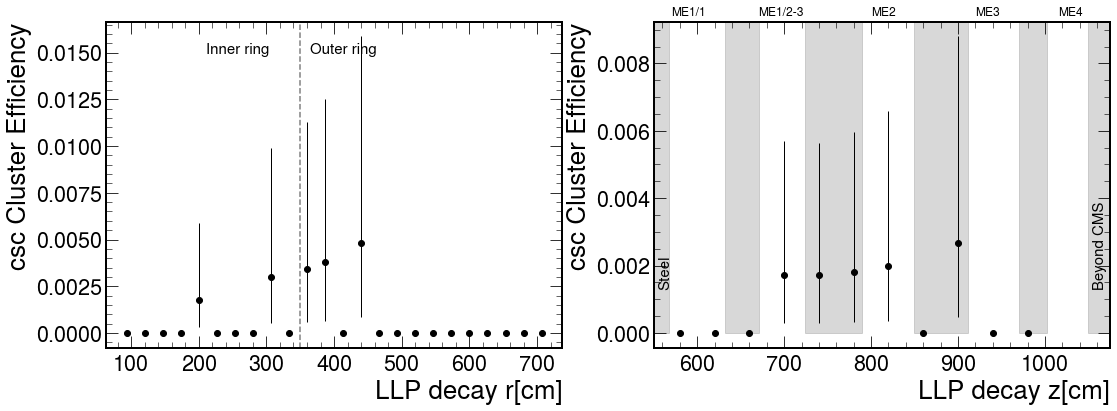

In [33]:
import mplhep
from hist.intervals import ratio_uncertainty
import matplotlib.patches as patches

plt.style.use(mplhep.style.CMS)


def ratio(reco, real, rax, ax, det):
    num = reco.project(ax)
    den = real.project(ax)
    rax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view(), "poisson"),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    rax.set_ylabel(f"{det} Cluster Efficiency")
    rax.set_xlabel(f"LLP decay {ax}[cm]")
    return rax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(550,1075)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax

def drawCSCr(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(350,linestyle="--",color='grey')
    ax.text(350-140,y_max*0.9, "Inner ring", fontsize=15)
    ax.text(350+15 ,y_max*0.9, "Outer ring", fontsize=15)
    return ax

sample = '1e3mm'
print(sample)
figsize = (18,6)
fig, (cscrax, csczax) = plt.subplots(1,2,figsize = figsize)

llp = out[sample]['llpCscDecayHist']
csc = out[sample]['cscClusterHist']
dt = out[sample]['dtClusterHist']

ratio(csc, llp, csczax, 'z', 'csc')
drawCSCz(csczax)

ratio(csc, llp, cscrax, 'r', 'csc')
drawCSCr(cscrax)
fig.savefig(sample + '.pdf')

3e2mm


/tmp/ipykernel_12324/3701476389.py:13: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_12324/3701476389.py:13: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


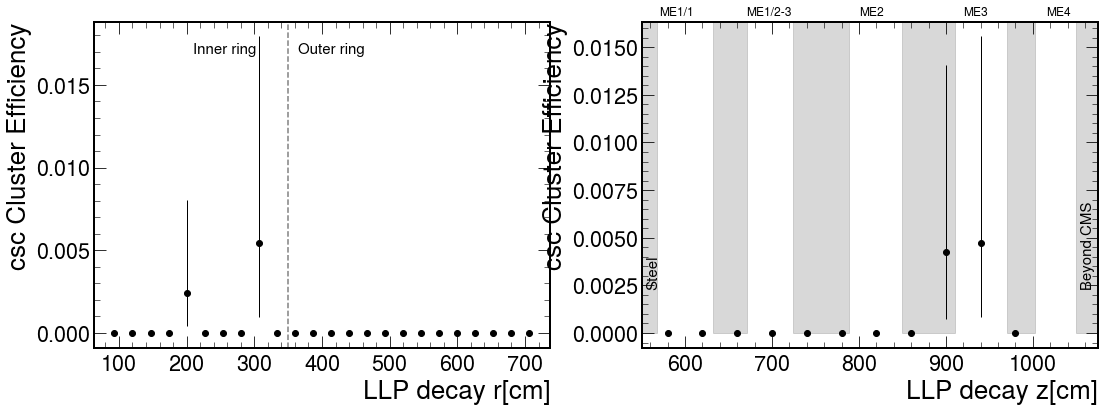

In [34]:
sample = '3e2mm'
print(sample)
figsize = (18,6)
fig, (cscrax, csczax) = plt.subplots(1,2,figsize = figsize)

llp = out[sample]['llpCscDecayHist']
csc = out[sample]['cscClusterHist']
dt = out[sample]['dtClusterHist']

ratio(csc, llp, csczax, 'z', 'csc')
drawCSCz(csczax)

ratio(csc, llp, cscrax, 'r', 'csc')
drawCSCr(cscrax)
fig.savefig(sample + '.pdf')

In [52]:
domain = 'root://cmsxrootd.fnal.gov/'
directory = ('/store/group/lpclonglived/displacedJetMuonNtuple'
           + '/V1p17/MC_Fall18/v2/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000'
           + '/Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_batch1_v2/220307_223055/0000/')

filename = domain + directory + 'displacedJetMuon_ntupler_100.root'
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    treepath='ntuples/llp',
    entry_stop=10000,
    metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

In [53]:
def R(x, y):
    return np.sqrt(x**2 + y**2)

#makes mask of particles who's parent is an LLP
llpPIDmomCut = (events.gParticleMotherId == 1000023)
#takes care of multi counting by picking index of first True value in each column
llpDaughterInd = ak.argmax(llpPIDmomCut, axis = 1, keepdims = True)
#llpMomInd = events.gParticleMotherIndex[llpDaughterInd]
llpMomInd = (events.gParticleId == 1000023)

llps = ak.zip(
                {
                    'X': events.gParticleProdVertexX[llpDaughterInd],
                    'Y': events.gParticleProdVertexY[llpDaughterInd],
                    'Z': events.gParticleProdVertexZ[llpDaughterInd], 
                    'R': R(events.gParticleProdVertexX[llpDaughterInd],
                           events.gParticleProdVertexY[llpDaughterInd]),
                    'pt': ak.ones_like(events.gParticlePhi[llpMomInd]),
                    'phi': events.gParticlePhi[llpMomInd],
                    'eta': events.gParticleEta[llpMomInd],
                    'mass': ak.ones_like(events.gParticlePhi[llpMomInd]),
                },
                with_name = 'PtEtaPhiMLorentzVector',
                behavior = vector.behavior,                 
              )

cscs = ak.zip(
                {
                    'X': events.cscRechitClusterX,
                    'Y': events.cscRechitClusterY,
                    'Z': events.cscRechitClusterZ, 
                    'R': R(events.cscRechitClusterX, events.cscRechitClusterY),
                    'pt': ak.ones_like(events.cscRechitClusterPhi),
                    'phi': events.cscRechitClusterPhi,
                    'eta': events.cscRechitClusterEta,
                    'mass': ak.ones_like(events.cscRechitClusterPhi),
                },
                with_name = 'PtEtaPhiMLorentzVector',
                behavior = vector.behavior,                 
              )

clust_llp_pairs = ak.cartesian({"clusts": cscs, "llps": llps}, axis = 1, nested = True)
delta_R = (clust_llp_pairs.clusts).delta_r(clust_llp_pairs.llps)
matched = clust_llp_pairs.clusts[delta_R < 0.3]

In [56]:
clust_llp_pairs.fields

['clusts', 'llps']

In [135]:
print(len(delta_R),len(clust_llp_pairs))

clust_llp_pairs = ak.zip({"clusts": clust_llp_pairs.clusts, "llps": clust_llp_pairs.llps, "dR": delta_R})

print('clust:  eta\t    phi       |llp: eta\t            phi\t           |dR')
for junk in clust_llp_pairs:

    for jazz in junk:
        print(f'\t{jazz.clusts.eta}\t    {jazz.clusts.phi}\t    {jazz.llps.eta}\t    {jazz.llps.phi}\t    {jazz.dR}')


3426 3426
clust:  eta	    phi       |llp: eta	            phi	           |dR
	[-2.16]	    [3.1]	    [-2.23]	    [0.2]	    [2.9]
	[-2.06]	    [-1.03]	    [-2.12]	    [-1.21]	    [0.19]
	[-1.94]	    [2.1]	    [-0.374]	    [0.273]	    [2.41]
	[2.23]	    [1.75]	    [2.3]	    [-0.793]	    [2.54]
	[1.7]	    [-0.835]	    [4.28]	    [-1.58]	    [2.69]
	[1.64]	    [-2.9]	    [2.13]	    [-1.87]	    [1.14]
	[-2.18]	    [0.184]	    [-0.277]	    [-0.0359]	    [1.92]
	[2.01]	    [-0.594]	    [-3.05]	    [2.56]	    [5.95]
	[2.18]	    [2.2]	    [-2.47]	    [1.46]	    [4.71]
	[-2.22]	    [-0.784]	    [0.614]	    [1.68]	    [3.75]
	[1.26]	    [-3.13]	    [-4.78]	    [-2.14]	    [6.12]
	[2.04]	    [0.781]	    [1.83]	    [-1.23]	    [2.02]
	[1.55]	    [2.01]	    [-1.55]	    [-0.8]	    [4.18]
	[2]	    [-1.01]	    [1.75]	    [-0.151]	    [0.894]
	[2.27]	    [-1.88]	    [1.03]	    [1.53]	    [3.13]
	[-2.35]	    [-2.83]	    [3.93]	    [-1.08]	    [6.52]
	[-2.07]	    [-2.77]	    [-0.531]	    [-0.369]	    [2.85

In [143]:
print(ak.min(clust_llp_pairs.clusts.phi))
print(ak.max(clust_llp_pairs.clusts.phi))

-3.1318145
3.1298788


In [99]:
count = 0
totCSC = 0
print('numLLP, numCSC')
for event in events:
    llpPIDcut = (event.gParticleId == 1000023)
    numLLP = ak.sum(llpPIDcut)
    numCSC = len(event.cscRechitClusterEta)
    if count < 10:
        print(f'{numLLP},      {numCSC}')
        count += 1
    totCSC += numCSC
print(f'.       .')
print(f'.       .')
print(f'.       . +')
print('__________')
print(f'{len(events)},   {totCSC}')

numLLP, numCSC
1,      1
1,      0
1,      0
1,      0
1,      0
1,      0
1,      0
1,      0
1,      0
1,      0
.       .
.       .
.       . +
__________
3426,   192


In [98]:
from itertools import product
for event in events:
    llpPIDcut = (event.gParticleId == 1000023)
    llps = ak.zip(# very bad way of doing this
                    {
                        'Eta': event.gParticleEta[llpPIDcut],
                        'Phi': event.gParticlePhi[llpPIDcut],
                    },
                    with_name = 'llps',
                    behavior = candidate.behavior,                 
                  )

    cscs = ak.zip(
                    {
                        'Eta': event.cscRechitClusterEta,
                        'Phi': event.cscRechitClusterPhi,
                    },
                    with_name = 'cscs',
                    behavior = candidate.behavior,                 
                  )
    if len(cscs.Phi) > 0:
        for llp, csc in product(llps, cscs):
            dR = np.sqrt((llp.Phi - csc.Phi)**2 + (llp.Eta - csc.Eta)**2)
            if dR < .4: 
                print(f'llp eta: {llp.Eta}, llp phi: {llp.Phi}, csc eta: {csc.Eta}, csc phi: {csc.Phi}, dR: {dR}')
    

NameError: name 'candidate' is not defined

In [ ]:
from itertools import product
dRlist = []
for event in events:
    llpPIDcut = (event.gParticleId == 1000023)
    llps = ak.zip(# very ugly way of doing this
                    {
                        'Eta': event.gParticleEta[llpPIDcut],
                        'Phi': event.gParticlePhi[llpPIDcut],
                    },
                    with_name = 'llps',
                    behavior = candidate.behavior,                 
                  )

    cscs = ak.zip(
                    {
                        'Eta': event.cscRechitClusterEta,
                        'Phi': event.cscRechitClusterPhi,
                    },
                    with_name = 'cscs',
                    behavior = candidate.behavior,                 
                  )
    if len(cscs.Phi) > 0:
        for llp, csc in product(llps, cscs):
            dR = np.sqrt((llp.Phi - csc.Phi)**2 + (llp.Eta - csc.Eta)**2)
            dRlist.append(dR)
print(np.mean(dRlist))